In [69]:
import os
import pathlib
import pickle5 as pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [66]:
tf.__version__

'2.6.0'

In [58]:
checkpoint_path = 'data/features/df.pkl'
with open(checkpoint_path, 'rb') as f:
    df = pickle.load(f)

extract_limit = df.extract_limit.values[0]  # previously found good audio limit
sr = int(df.sr.values[0]) # sample rate

# NB cannot use select_dtypes since features are stored under *int* index *names*
X = df[[c for c in df.columns.values if isinstance(c, int)]] #  + ['audio', 'sr']

print('limit ', extract_limit)
print('sr ', sr)
print(extract_limit / sr)
print('X ', X.shape)

limit  110250
sr  22050
5.0
X  (13700, 160)


In [43]:
wav = df.audio.values[0]
print(len(wav))
waveform = tf.convert_to_tensor(wav)
print(signal.dtype)

frame_length = 255  # window length in number of samples (M), should be odd 
frame_step = 128    # hop size in number of samples
fft_length = None   # size of FFT (N), if None computed automatically

125465
<dtype: 'float32'>


In [59]:
def get_spectrogram(waveform, input_len: int=sr):
    waveform = waveform[:input_len]
    waveform = tf.cast(waveform, dtype=tf.float32)
    
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    zero_padding = tf.zeros([input_len] - tf.shape(waveform), dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    return spectrogram[..., tf.newaxis]


In [60]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

In [61]:
spectrogram = get_spectrogram(waveform, input_len=extract_limit)

waveform.shape, spectrogram.shape

(TensorShape([125465]), TensorShape([860, 129, 1]))

/Users/home/bin/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


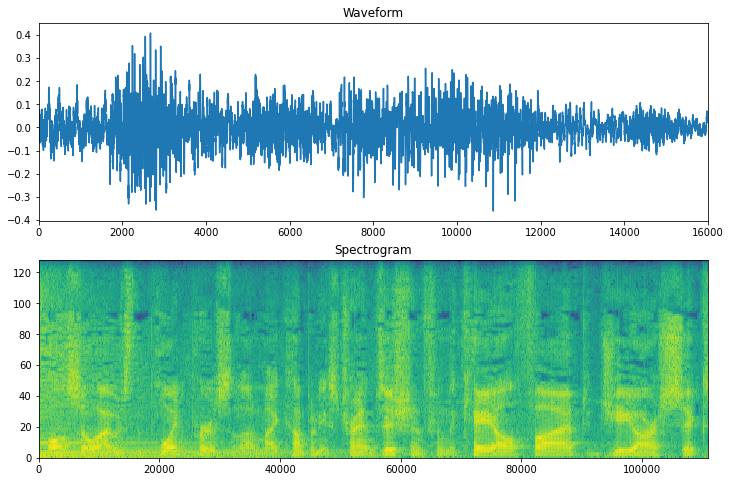

In [62]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [76]:
df['spectrogram'] = df.audio.apply(get_spectrogram)

In [92]:
X = np.array([np.asarray(x).astype('float32') for x in df.spectrogram])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, df.negativity, test_size=0.2, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(10960, 171, 129, 1) (10960,)
(1370, 171, 129, 1) (1370,)
(1370, 171, 129, 1) (1370,)


In [94]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_val = tf.data.Dataset.from_tensor_slices(X_val)
y_val = tf.data.Dataset.from_tensor_slices(y_val)

X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

In [ ]:
# batch_size = 64
# train_ds = train_ds.batch(batch_size)
# val_ds = val_ds.batch(batch_size)

# # reduce read latency while training the model
# train_ds = train_ds.cache().prefetch(AUTOTUNE)
# val_ds = val_ds.cache().prefetch(AUTOTUNE)

## Model

In [97]:
for spectrogram in X_train.take(1):
    input_shape = spectrogram.shape

norm_layer = layers.Normalization()
norm_layer.adapt(data=X_train)

num_labels = 2
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),  # downsample 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [99]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [101]:
EPOCHS = 10
history = model.fit(
    
    # validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

ValueError: `y` argument is not supported when using dataset as input.

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# Evaluate the model performance